# Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. 

With it's diverse culture, comes diverse cultural food. So as part of this project, we will list and visualize all major parts of New York City that have  great French resturants.


# Data


Data For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset 

Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

Data source : Fousquare API

Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only french resturants. 

GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 

Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.


In [ ]:
# Importing libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 102kB 3.9MB/s 
Libraries imported.




Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.


In [ ]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [ ]:
def get_venues(lat,lng):
    
    #set variables
    CODE = 'YGFEHA4LIYPOPAVCJGOP3VZJXD5EP01NWR2M5DL1CG4YAE0H#_=_'
    CLIENT_ID = 'DV4Z5RO1FG2GFVSZE42KHY1QGZSQB5QB13S11OIGJS3L2KNI' # your Foursquare ID
    CLIENT_SECRET = 'I1GBDHPRWAIVVL3DNMQLZHFFWQVTQR3AW5LJBT0J33JH2V4U' # your Foursquare Secret
    ACCESS_TOKEN = '5TQJIVKCA15AYK1MNAFT4GIJHBALP24XJEZ0GLCPIVZAZMGO' # your FourSquare Access Token
    VERSION = '20180605' # Foursquare API version
    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [ ]:
def get_venue_details(venue_id):
        
     #set variables
    CODE = 'YGFEHA4LIYPOPAVCJGOP3VZJXD5EP01NWR2M5DL1CG4YAE0H#_=_'
    CLIENT_ID = 'DV4Z5RO1FG2GFVSZE42KHY1QGZSQB5QB13S11OIGJS3L2KNI' # your Foursquare ID
    CLIENT_SECRET = 'I1GBDHPRWAIVVL3DNMQLZHFFWQVTQR3AW5LJBT0J33JH2V4U' # your Foursquare Secret
    ACCESS_TOKEN = '5TQJIVKCA15AYK1MNAFT4GIJHBALP24XJEZ0GLCPIVZAZMGO' # your FourSquare Access Token
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.


In [ ]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [ ]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

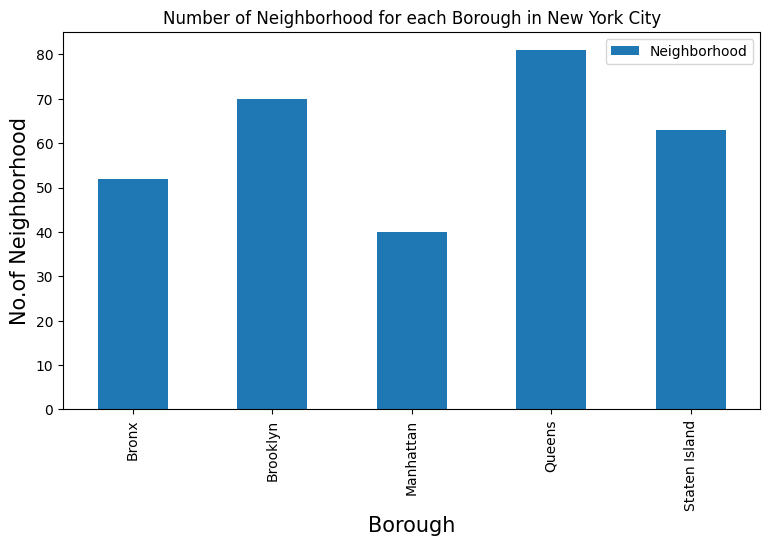

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

We will collect French resturants for each Neighborhood

In [ ]:
# prepare neighborhood list that contains french resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_resturants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_resturants)))
    for resturant_detail in french_resturants.values.tolist():
        id, name , category=resturant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) French Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) French Resturants in Norwood, Bronx:0
done
( 10 / 306 ) French Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) French Resturants in Baychester, Bronx:0
done
( 12 / 306 ) French Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) French Resturants in City Island, Bronx:1
done
( 14 / 306 ) French Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) French Resturants in University Heights, Bronx:0
done
( 16 / 306 ) French Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) French Resturants in Ford

In [ ]:
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock


In [ ]:
french_rest_ny.shape

(81, 4)

We got **81 French Resturants** across New York City

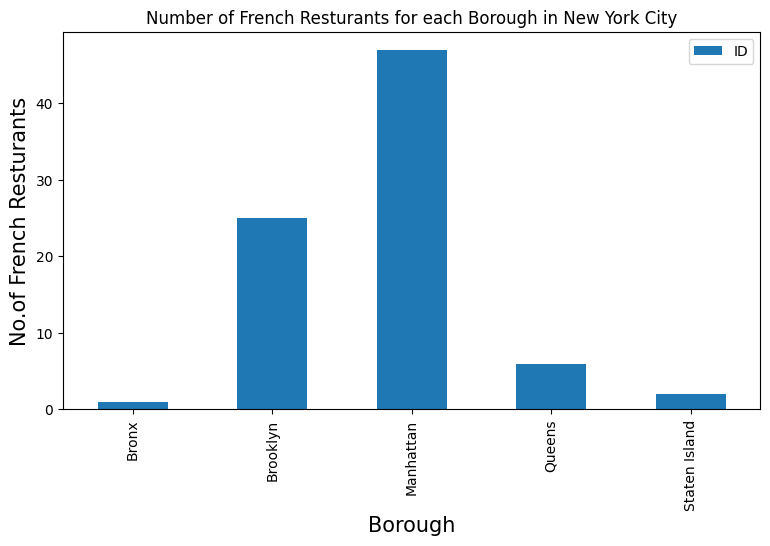

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan has the largest number of french resturants

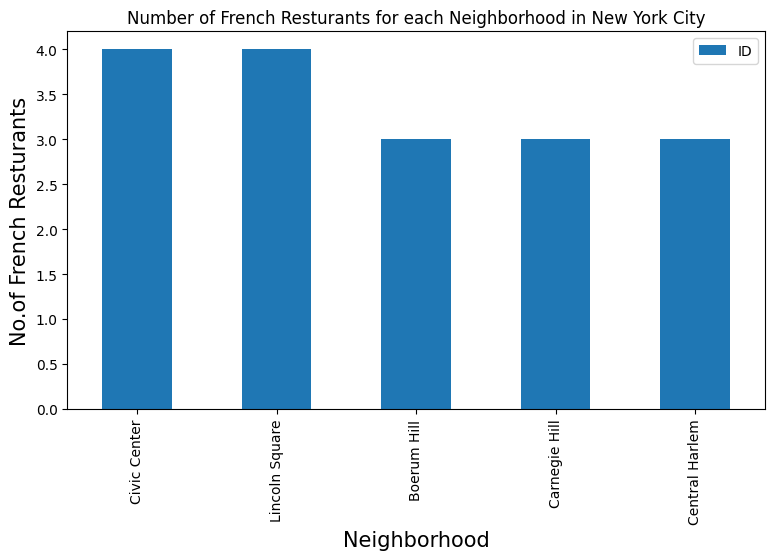

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
french_rest_ny[french_rest_ny['Neighborhood']=='Civic Center']

,Borough,Neighborhood,ID,Name
37,Manhattan,Lincoln Square,414ccc00f964a520d21c1fe3,Cafe Luxembourg
38,Manhattan,Lincoln Square,478cd1f3f964a520444d1fe3,Bar Boulud
39,Manhattan,Lincoln Square,3fd66200f964a520bee91ee3,Jean-Georges
40,Manhattan,Lincoln Square,49e7897ff964a520b6641fe3,Nougatine at Jean Georges




So Civic Center (Manhattan) and Lincoln Square (Manhattan) have the highest number of French Resturants with a total count of 4 each neighborhood.

Now we will get the ranking of each resturant for further analysis.


In [ ]:
# prepare neighborhood list that contains French resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
french_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(french_rest_ny),')','processed')
    french_rest_stats_ny =french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     12     7.5     7
( 1 / 81 ) processed
                         ID     Name  Likes  Rating  Tips
0  5bf358689fca56002c251a87  Citroën     23     8.5     3
( 2 / 81 ) processed
                         ID           Name  Likes  Rating  Tips
0  58fd34584382ab70ad90083e  Chez Ma Tante    219     8.9    60
( 3 / 81 ) processed
                         ID      Name  Likes  Rating  Tips
0  4bcf1883c564ef3ba33beff0  Le Gamin    159     7.9    73
( 4 / 81 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e7d174cb6340a4da75a2cca  Le Paddock    138     8.8    56
( 5 / 81 ) processed
                         ID       Name  Likes  Rating  Tips
0  50b99e4ae4b0c22ba9633dfd  Mominette    339     8.0    81
( 6 / 81 ) processed
                         ID            Name  Likes  Rating  Tips
0  5003007de4b06d50188aa593  Le Paris Dakar    149     8.5    42
( 7 / 81 ) processed

In [ ]:
french_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,23,8.5,3
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,219,8.9,60
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,159,7.9,73
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,138,8.8,56


In [ ]:
french_rest_ny.shape

(81, 4)

So we got data for all resturants Now lets save this data to a csv sheet.

In [ ]:
french_rest_stats_ny.to_csv('french_rest_stats_ny.csv', index=False)

We will now read the csv document to have all data secure

In [ ]:
french_rest_stats_ny = pd.read_csv('french_rest_stats_ny.csv')

In [ ]:
french_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,23,8.5,3
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,219,8.9,60
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,159,7.9,73
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,138,8.8,56


In [ ]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       81 non-null     object 
 1   Neighborhood  81 non-null     object 
 2   ID            81 non-null     object 
 3   Name          81 non-null     object 
 4   Likes         81 non-null     int64  
 5   Rating        81 non-null     float64
 6   Tips          81 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.6+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [ ]:
french_rest_stats_ny['Likes']=french_rest_stats_ny['Likes'].astype('float64')
french_rest_stats_ny['Tips']=french_rest_stats_ny['Tips'].astype('float64')
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       81 non-null     object 
 1   Neighborhood  81 non-null     object 
 2   ID            81 non-null     object 
 3   Name          81 non-null     object 
 4   Likes         81 non-null     float64
 5   Rating        81 non-null     float64
 6   Tips          81 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.6+ KB


Data is now correct

Let's study which restaurants have the maximum rating

In [ ]:
# Resturant with maximum Rating
french_rest_stats_ny.iloc[french_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1857
Rating                               9.3
Tips                                 526
Name: 53, dtype: object

Let's study which restaurants have the maximum tips

In [ ]:
# Resturant with maximum Tips
french_rest_stats_ny.iloc[french_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              3fd66200f964a52070e91ee3
Name                           Balthazar
Likes                               3040
Rating                               8.7
Tips                                1050
Name: 50, dtype: object

Now we are calculating the average of ratings per neighborhood

In [ ]:
ny_neighborhood_stats=french_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [ ]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
46,West Village,9.15
16,East Harlem,9.10
39,South Side,9.00
8,Chelsea,9.00
38,Soho,8.95
21,Greenwich Village,8.95
33,Noho,8.90
31,Midtown,8.90
48,Yorkville,8.80
47,Windsor Terrace,8.80




Above are the top neighborhoods with top average rating of french resturant


In [ ]:
ny_borough_stats=french_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [ ]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Rating
2,Manhattan,8.638298
1,Brooklyn,8.408000
3,Queens,8.000000
0,Bronx,7.500000
4,Staten Island,7.100000


Similarly these are the top average rating of french Resturants for each Borough

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [ ]:
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Chelsea,9.00
16,East Harlem,9.10
39,South Side,9.00
46,West Village,9.15


We will join this dataset to original new york data to get lonitude and latitude

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.00
1,Staten Island,Chelsea,40.594726,-74.189560,9.00
2,Manhattan,East Harlem,40.792249,-73.944182,9.10
3,Brooklyn,South Side,40.710861,-73.958001,9.00
4,Manhattan,West Village,40.734434,-74.006180,9.15


Now we will show this data on a map

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [ ]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [ ]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion



1.   West Village (Manhattan)  and East Harlem (Manhattan) are some of the best neighborhoods for french restaurants.

1. Manhattan has a potential french restaurant market and it is the best place to stay if you enjoy french cuisine.
1. Staten Island ranks last in average rating of french Resturants.

1. Limitations: The ranking is purely based on restaurant raitings. The accuracy of data purely depends on the data provided by FourSquare


